<a href="https://colab.research.google.com/github/tylerlum/DrawNames/blob/master/Behavioral_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Import data
!git clone https://github.com/tylerlum/self-driving-car-data-track-1

fatal: destination path 'self-driving-car-data-track-1' already exists and is not an empty directory.


In [2]:
!ls self-driving-car-data-track-1

driving_log.csv  IMG


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as npimg
import os

## Keras
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

import cv2
import pandas as pd
import random
import ntpath

## Sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [4]:
## Store data
datadir = 'self-driving-car-data-track-1'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\center_2018_12_08_17_31_10_104.jpg,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\left_2018_12_08_17_31_10_104.jpg,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\right_2018_12_08_17_31_10_104.jpg,0.0,0.0,0.0,0.000079
1,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\center_2018_12_08_17_31_10_208.jpg,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\left_2018_12_08_17_31_10_208.jpg,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\right_2018_12_08_17_31_10_208.jpg,0.0,0.0,0.0,0.000079
2,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\center_2018_12_08_17_31_10_311.jpg,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\left_2018_12_08_17_31_10_311.jpg,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\right_2018_12_08_17_31_10_311.jpg,0.0,0.0,0.0,0.000078
3,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\center_2018_12_08_17_31_10_417.jpg,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\left_2018_12_08_17_31_10_417.jpg,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\right_2018_12_08_17_31_10_417.jpg,0.0,0.0,0.0,0.000081
4,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\center_2018_12_08_17_31_10_517.jpg,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\left_2018_12_08_17_31_10_517.jpg,C:\Users\tlum1\Desktop\Self-Driving-Car-Data\IMG\right_2018_12_08_17_31_10_517.jpg,0.0,0.0,0.0,0.000078


In [5]:
def path_leaf(path):
  """Get tail of path"""
  head, tail = ntpath.split(path)
  return tail

## Remove path of images
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_12_08_17_31_10_104.jpg,left_2018_12_08_17_31_10_104.jpg,right_2018_12_08_17_31_10_104.jpg,0.0,0.0,0.0,0.000079
1,center_2018_12_08_17_31_10_208.jpg,left_2018_12_08_17_31_10_208.jpg,right_2018_12_08_17_31_10_208.jpg,0.0,0.0,0.0,0.000079
2,center_2018_12_08_17_31_10_311.jpg,left_2018_12_08_17_31_10_311.jpg,right_2018_12_08_17_31_10_311.jpg,0.0,0.0,0.0,0.000078
3,center_2018_12_08_17_31_10_417.jpg,left_2018_12_08_17_31_10_417.jpg,right_2018_12_08_17_31_10_417.jpg,0.0,0.0,0.0,0.000081
4,center_2018_12_08_17_31_10_517.jpg,left_2018_12_08_17_31_10_517.jpg,right_2018_12_08_17_31_10_517.jpg,0.0,0.0,0.0,0.000078


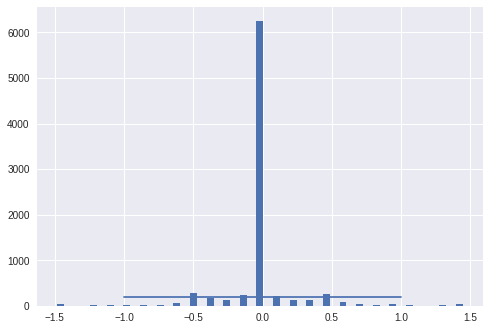

In [6]:
## Visualize data
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = bins[:-1] + bins[1:] * 0.5  # center the bins to 0

## Plot
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Total data: 8197
Removed: 6230
Remaining: 1967


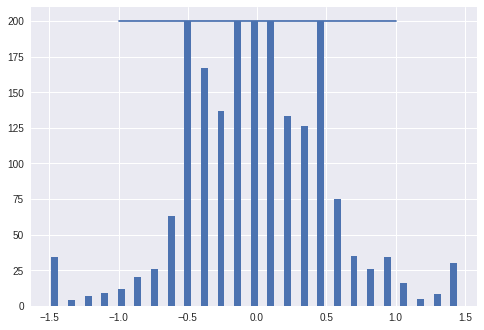

In [7]:
## Unskew data: for bins with >samples_per_bin, shuffle them and remove enough to have samples_per_bin 
print('Total data: {0}'.format(len(data)))

## Make list of indices to remove
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    steering_angle = data['steering'][i]
    if steering_angle >= bins[j] and steering_angle <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
  
## Remove from extras from list
data.drop(data.index[remove_list], inplace=True)
print('Removed: {0}'.format(len(remove_list)))
print('Remaining: {0}'.format(len(data)))

## Plot
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [0]:
def load_img_steering(datadir, df):
  """Get img and steering data into arrays"""
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)
  

Training Samples: 1573
Valid Samples: 394


Text(0.5,1,'Validation set')

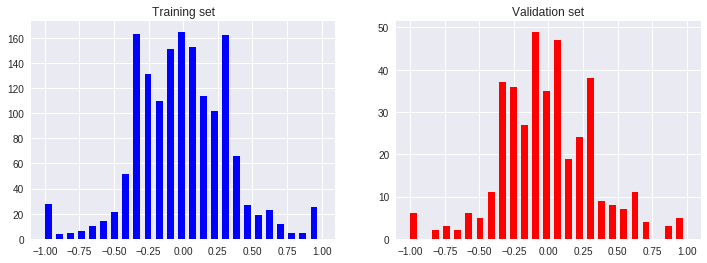

In [9]:
## Split data into training and validation
X_train, X_valid, Y_train, Y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=0)

## Check that data is valid
print("Training Samples: {}\nValid Samples: {}".format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(Y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(Y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [0]:
def img_preprocess(img):
  """Take in path of img, returns preprocessed image"""
  img = npimg.imread(img)
  
  ## Crop image to remove unnecessary features
  img = img[60:135, :, :]
  
  ## Change to YUV image
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  
  ## Gaussian blur
  img = cv2.GaussianBlur(img, (3, 3), 0)
  
  ## Decrease size for easier processing
  img = cv2.resize(img, (200, 66))
  
  ## Normalize values
  img = img / 255
  return img

Text(0.5,1,'Preprocessed Image')

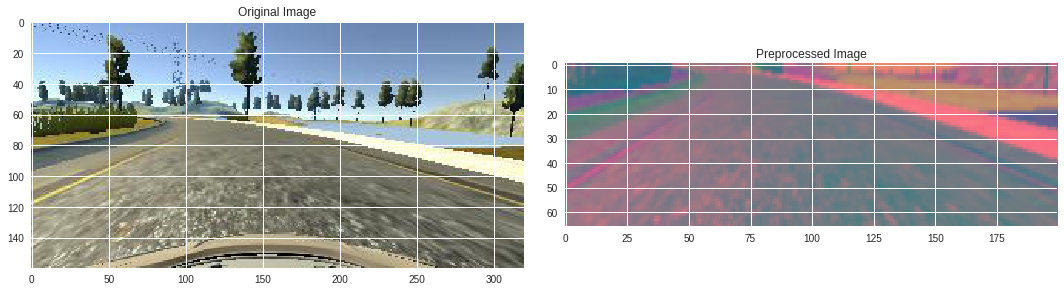

In [11]:
## Get any image
image = image_paths[100]
original_image = npimg.imread(image)
preprocessed_image = img_preprocess(image)

## Compare original and preprocessed image
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')

In [0]:
## Preprocess data
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

(1573, 66, 200, 3)


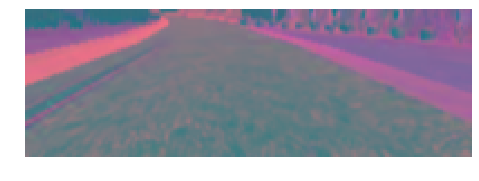

In [13]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [15]:
model = nvidia_model()
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
__________

In [16]:
history = model.fit(X_train, Y_train, epochs=30, validation_data=(X_valid, Y_valid), batch_size=100, verbose=1, shuffle=1)

Train on 1573 samples, validate on 394 samples
Epoch 1/30
1573/1573 [==============================] - 3s 2ms/step - loss: 0.6672 - val_loss: 0.1096
Epoch 2/30
1573/1573 [==============================] - 1s 693us/step - loss: 0.1750 - val_loss: 0.1101
Epoch 3/30
1573/1573 [==============================] - 1s 694us/step - loss: 0.1382 - val_loss: 0.1050
Epoch 4/30
1573/1573 [==============================] - 1s 694us/step - loss: 0.1289 - val_loss: 0.1050
Epoch 5/30
1573/1573 [==============================] - 1s 688us/step - loss: 0.1205 - val_loss: 0.0996
Epoch 6/30
1573/1573 [==============================] - 1s 696us/step - loss: 0.1170 - val_loss: 0.0978
Epoch 7/30
1573/1573 [==============================] - 1s 692us/step - loss: 0.1200 - val_loss: 0.0992
Epoch 8/30
1573/1573 [==============================] - 1s 678us/step - loss: 0.1118 - val_loss: 0.0935
Epoch 9/30
1573/1573 [==============================] - 1s 702us/step - loss: 0.1081 - val_loss: 0.0936
Epoch 10/30
1573/15

Text(0.5,0,'Epoch')

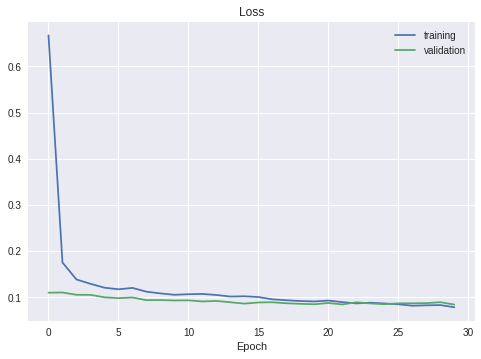

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
model.save('model3.h5')

In [0]:
from google.colab import files
files.download('model3.h5')